In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

# Compatibility for PyTorch >=2.6 with Lightning/NeuralProphet checkpoint restore
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

try:
    import plotly.express as px
    import plotly.graph_objects as go
except ImportError:
    warnings.warn(
        "Plotly is not installed. Interactive plots will not work. "
        "Run: pip install plotly"
    )

try:
    from neuralprophet import NeuralProphet
except ImportError as exc:
    raise ImportError(
        "NeuralProphet is not installed. Run: pip install neuralprophet"
    ) from exc

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


# 3.3 NeuralProphet as Advanced Time Series Model

In [2]:
# Loading my 300k sample data
df = pd.read_parquet('../data/processed/cfpb_sample_300k.parquet')

In [3]:
print(f"Loaded {len(df):,} rows & {len(df.columns)} columns")
df.head()

Loaded 300,000 rows & 23 columns


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_quarter,geo,region,stratum,sample_n
0,2012-03-14,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,"BANK OF AMERICA, NATIONAL ASSOCIATION",ND,58503,...,2012-03-15,Closed with relief,Yes,No,35052,2012Q1,ND,Midwest,Bank account or service|2012Q1|Midwest,4
1,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,TCF NATIONAL BANK,MN,55125,...,2012-03-21,Closed with relief,Yes,No,37573,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
2,2012-03-22,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,WELLS FARGO & COMPANY,MN,55110,...,2012-03-23,Closed without relief,Yes,Yes,39793,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
3,2012-03-07,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,Synovus Bank,OH,44108,...,2012-03-16,Closed without relief,Yes,No,34571,2012Q1,OH,Midwest,Bank account or service|2012Q1|Midwest,4
4,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,PNC Bank N.A.,PA,18944,...,2012-03-23,Closed without relief,Yes,Yes,37047,2012Q1,PA,Northeast,Bank account or service|2012Q1|Northeast,6


### 3.3.1 Preparing NeuralProphet Time Series

In [4]:
# Filter to Credit reporting and build South vs Non-South quarterly series
df_cr = df[df['Product'].str.contains('Credit reporting', case=False, na=False)].copy()
df_cr['segment'] = np.where(df_cr['region'].eq('South'), 'South', 'Non-South')

quarterly_counts = (
    df_cr.groupby(['year_quarter', 'segment'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
 )
quarterly_counts.index = pd.PeriodIndex(quarterly_counts.index, freq='Q')

print('Shape:', quarterly_counts.shape)
quarterly_counts.tail()

Shape: (54, 2)


segment,Non-South,South
year_quarter,,
2025Q1,9884,12840
2025Q2,10295,14422
2025Q3,12035,17586
2025Q4,13505,20563
2026Q1,4556,6750


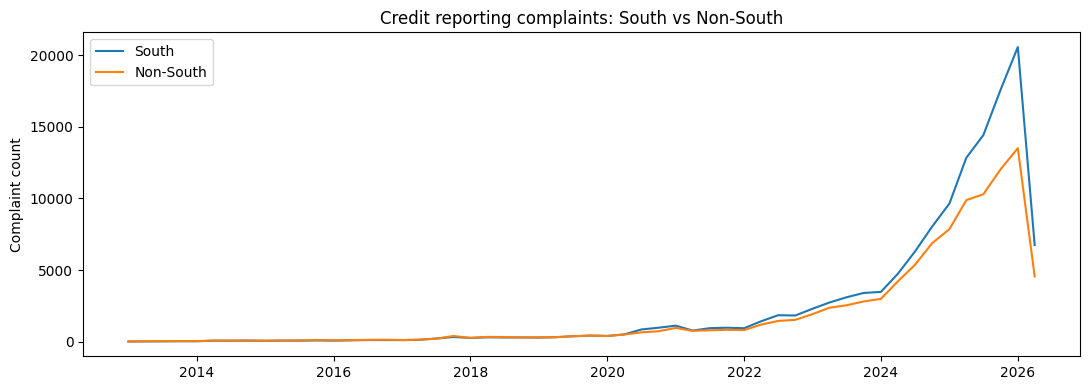

In [5]:
fig, ax = plt.subplots(figsize=(11, 4))
for seg in ['South', 'Non-South']:
    s = quarterly_counts[seg].copy()
    s.index = s.index.to_timestamp(how='end')
    ax.plot(s.index, s.values, label=seg)
ax.set_title('Credit reporting complaints: South vs Non-South')
ax.set_ylabel('Complaint count')
ax.legend()
plt.tight_layout()
plt.show()

### 3.3.2 Train/Test Split for Backtesting

In [ ]:
def split_series(ts):
    test_size = 8 if len(ts) >= 24 else max(4, int(round(len(ts) * 0.2)))
    test_size = min(test_size, len(ts) - 8) if len(ts) > 12 else max(1, len(ts)//3)
    train = ts.iloc[:-test_size].copy()
    test = ts.iloc[-test_size:].copy()
    return train, test

print('Split helper ready')

Split helper ready


### 3.3.3 Fit NeuralProphet and Evaluate on Holdout

In [ ]:
np_results = []
np_models = {}

for seg in ['South', 'Non-South']:
    ts = quarterly_counts[seg].astype(float)
    train, test = split_series(ts)

    train_df = pd.DataFrame({'ds': train.index.to_timestamp(how='start'), 'y': train.values})
    test_df = pd.DataFrame({'ds': test.index.to_timestamp(how='start'), 'y': test.values})

    model = NeuralProphet(
        n_lags=4,
        n_forecasts=1,
        changepoints_range=0.9,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive'
    )

    _ = model.fit(train_df, freq='QS', progress='off')
    future_test = model.make_future_dataframe(train_df, periods=len(test_df), n_historic_predictions=True)
    forecast_test = model.predict(future_test)

    pred_test = forecast_test[['ds', 'yhat1']].dropna().copy()
    pred_test['year_quarter'] = pd.PeriodIndex(pred_test['ds'], freq='Q')
    pred_test = pred_test.drop_duplicates('year_quarter', keep='last').set_index('year_quarter')

    test_pred = pred_test.reindex(test.index)['yhat1']
    if test_pred.isna().any():
        yhat_tail = forecast_test['yhat1'].dropna().tail(len(test)).to_numpy()
        if len(yhat_tail) != len(test):
            raise ValueError(
                f'Unable to align NeuralProphet predictions for {seg}: '
                f'got {len(yhat_tail)} predictions for {len(test)} test points.'
            )
        test_pred = pd.Series(yhat_tail, index=test.index)

    holdout_mae = mean_absolute_error(test, test_pred)
    holdout_rmse = np.sqrt(mean_squared_error(test, test_pred))
    holdout_pct = (holdout_mae / test.mean()) * 100

    np_models[seg] = {'ts': ts, 'test': test, 'test_pred': test_pred}
    np_results.append({
        'segment': seg,
        'holdout_mae': holdout_mae,
        'holdout_rmse': holdout_rmse,
        'mae_pct_of_mean': holdout_pct
    })

result_summary = pd.DataFrame(np_results)
result_summary

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 78.261% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 350


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number                     for the learning rate finder (204). The results might not be optimal.
Finding best initial lr: 100%|██████████| 204/204 [00:05<00:00, 37.77it/s]


Training: |          | 0/? [00:34<?, ?it/s, v_num=3, train_loss=0.00351, reg_loss=0.000, MAE=85.80, RMSE=128.0, Loss=0.00308, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 78.261% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 78.723% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 78.723% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.78it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


ValueError: Length of values (1) does not match length of index (8)

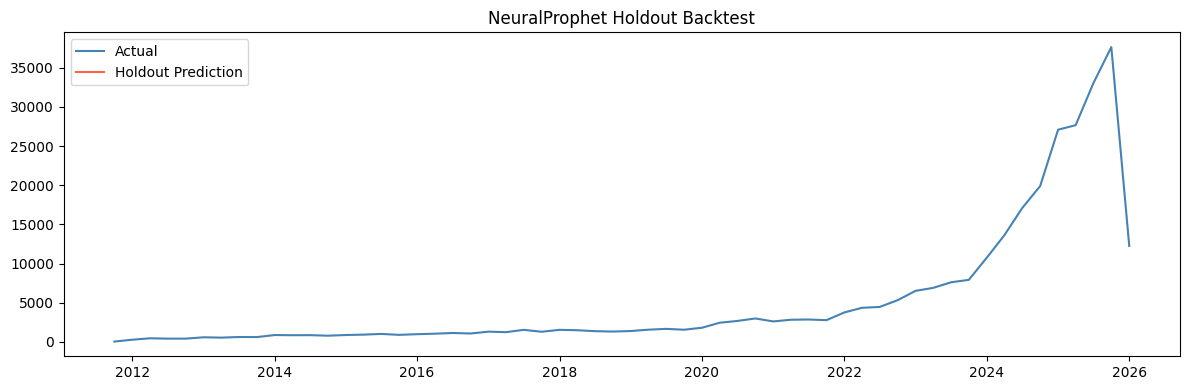

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
for i, seg in enumerate(['South', 'Non-South']):
    ax = axes[i]
    ts = np_models[seg]['ts']
    pred = np_models[seg]['test_pred']
    ax.plot(ts.index.to_timestamp(how='end'), ts.values, label='Actual', color='steelblue')
    ax.plot(pred.index.to_timestamp(how='end'), pred.values, label='Holdout Prediction', color='tomato')
    ax.set_title(f'NeuralProphet Holdout Backtest ({seg})')
    ax.legend()
plt.tight_layout()
plt.show()

### 3.3.4 Refit on Full Data and Forecast Next 4 Quarters

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 81.034% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 310


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number                     for the learning rate finder (204). The results might not be optimal.
Finding best initial lr: 100%|██████████| 204/204 [00:01<00:00, 157.69it/s]


Training: |          | 0/? [00:39<?, ?it/s, v_num=2, train_loss=0.00655, reg_loss=0.000, MAE=987.0, RMSE=1.62e+3, Loss=0.00701, RegLoss=0.000]  

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 81.034% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 79.661% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 79.661% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in 'y' column.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.40it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


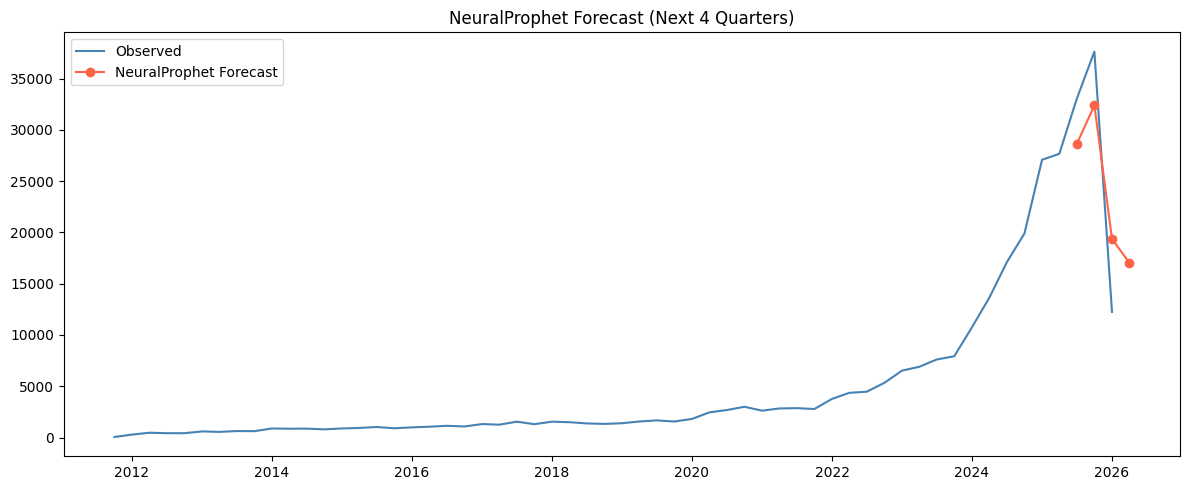

Next 4Q Forecast (rounded):
ds
2025-07-01    28611.0
2025-10-01    32382.0
2026-01-01    19370.0
2026-04-01    17051.0
Name: yhat1, dtype: float32


In [ ]:
all_forecasts = {}

for seg in ['South', 'Non-South']:
    ts = quarterly_counts[seg].astype(float)
    np_df = pd.DataFrame({'ds': ts.index.to_timestamp(how='start'), 'y': ts.values})

    final_model = NeuralProphet(
        n_lags=4,
        n_forecasts=1,
        changepoints_range=0.9,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive'
    )

    _ = final_model.fit(np_df, freq='QS', progress='off')
    future_full = final_model.make_future_dataframe(np_df, periods=4, n_historic_predictions=True)
    forecast_full = final_model.predict(future_full)
    forecast_np = forecast_full[['ds', 'yhat1']].tail(4).set_index('ds')['yhat1']
    all_forecasts[seg] = forecast_np

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
for i, seg in enumerate(['South', 'Non-South']):
    ax = axes[i]
    ts = quarterly_counts[seg].astype(float)
    fc = all_forecasts[seg]
    ax.plot(ts.index.to_timestamp(how='end'), ts.values, label='Observed', color='steelblue')
    ax.plot(fc.index, fc.values, marker='o', label='NeuralProphet Forecast', color='tomato')
    ax.set_title(f'NeuralProphet Forecast ({seg})')
    ax.legend()

plt.tight_layout()
out_dir = '../reports/figures'
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f'{out_dir}/neuralprophet_credit_reporting_south_vs_others.png', dpi=150)
plt.show()

print('Next 4Q Forecast (rounded):')
for seg in ['South', 'Non-South']:
    print(f'\n{seg}:')
    print(all_forecasts[seg].round(0))

### 3.3.5 Results

In [ ]:
result_summary = result_summary.copy()
result_summary['holdout_mae'] = result_summary['holdout_mae'].round(1)
result_summary['holdout_rmse'] = result_summary['holdout_rmse'].round(1)
result_summary['mae_pct_of_mean'] = result_summary['mae_pct_of_mean'].round(1)
result_summary

,Metric,Value
0,Holdout MAE,2773.7
1,Holdout RMSE,2773.7
2,MAE/Mean(y) %,20.3
3,Forecast Start,2025Q3
4,Forecast End,2026Q2


NeuralProphet extends the ML baseline with autoregression + trend changepoints, and is intended to better handle structural breaks than SARIMA/XGBoost in this series.

**Suggested next refinements**
- Tune n_lags, changepoint/regularization, and seasonality strength.
- Add external regressors (macro indicators, policy/event markers).
- Compare final metrics side-by-side against 03a and 03b in a combined table.